<a href="https://www.kaggle.com/code/aabdollahii/gridworld-with-q-learning-sarsa?scriptVersionId=263562035" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:#0d1117; color:#c9d1d9; padding:20px; border-radius:8px; font-family:Segoe UI, sans-serif; line-height:1.6;">
  <h1 style="color:#58a6ff;">🏁 GridWorld: Q-Learning vs SARSA</h1>
  
  <p>
    In this project, we explore two cornerstone algorithms of <strong>Classic Reinforcement Learning</strong>:
    <span style="color:#d2a8ff;">Q-Learning</span> and <span style="color:#d2a8ff;">SARSA</span>.
    Using a custom-built <strong>GridWorld</strong> environment, we train an agent to navigate from a start
    position to a goal while avoiding traps and obstacles.
  </p>

  <h2 style="color:#58a6ff;">🔍 Why GridWorld?</h2>
  <p>
    GridWorld provides a clean, interpretable environment where we can visualize learning policies 
    and compare algorithm behaviors side-by-side. Adding traps and movement penalties 
    forces each algorithm to balance risk and reward — a great setup to see their differences in action.
  </p>

  <h2 style="color:#58a6ff;">📈 Project Goals</h2>
  <ul>
    <li>Implement a minimal but functional GridWorld without external dependencies.</li>
    <li>Train agents using <strong>Q-Learning</strong> (off-policy) and <strong>SARSA</strong> (on-policy).</li>
    <li>Track and compare learning curves, convergence speeds, and final policies.</li>
    <li>Visualize results in a dark-themed, publication-ready format.</li>
  </ul>

  <h2 style="color:#58a6ff;">🧠 Key Difference</h2>
  <p>
    <strong>Q-Learning</strong> always updates toward the <em>best possible action</em> in the next state, 
    even if the agent doesn't take it.<br>
    <strong>SARSA</strong> updates based on the <em>actual action</em> taken in the next state.
    This subtle change can lead to dramatically different navigation styles.
  </p>

  <p style="margin-top:15px; font-style:italic; color:#8b949e;">
    By the end of this notebook, you'll see how two seemingly similar algorithms 
    can make very different choices in the same world.
  </p>
</div>


<div style="background-color:#0d1117; color:#c9d1d9; padding:18px; border-radius:8px; font-family:Segoe UI, sans-serif; line-height:1.6;">
  <h2 style="color:#58a6ff;">🛠 Step 1 — Setup & Imports</h2>
  <p>
    In this step, we prepare the core components needed for our <strong>GridWorld</strong> project:
  </p>
  <ul>
    <li>Importing <code>numpy</code> and <code>matplotlib</code> for numerical operations and visualizations.</li>
    <li>Configuring <strong>dark-themed plots</strong> for a cleaner Kaggle output.</li>
    <li>Setting a <strong>random seed</strong> for reproducibility across runs.</li>
    <li>Defining the <strong>environment grid size</strong> and available <strong>agent actions</strong>.</li>
  </ul>
  <p>
    This minimal setup ensures our environment is ready for defining GridWorld mechanics 
    and plugging in <span style="color:#d2a8ff;">Q-Learning</span> and <span style="color:#d2a8ff;">SARSA</span> algorithms in the next steps.
  </p>
</div>


In [1]:

# Step 1 — Setup & Imports


import numpy as np
import matplotlib.pyplot as plt
import random

# Optional: make plots dark-themed by default for Kaggle
plt.style.use('dark_background')

# For reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Environment size
GRID_ROWS = 6
GRID_COLS = 6

# Actions (Up, Right, Down, Left)
ACTIONS = ['U', 'R', 'D', 'L']
ACTION_IDX = {a: i for i, a in enumerate(ACTIONS)}

print(f"Environment: {GRID_ROWS}x{GRID_COLS} | Actions: {ACTIONS}")


Environment: 6x6 | Actions: ['U', 'R', 'D', 'L']


<div style="background-color:#0d1117; color:#c9d1d9; padding:18px; border-radius:8px; font-family:Segoe UI, sans-serif; line-height:1.6;">
  <h2 style="color:#58a6ff;">🌍 Step 2 — Building the GridWorld Environment</h2>
  <p>
    Here we define our custom <strong>GridWorld</strong> — a rectangular grid where an agent
    navigates from a <span style="color:#d2a8ff;">start position</span> to a <span style="color:#d2a8ff;">goal</span>,
    avoiding obstacles and traps along the way.
  </p>
  <h3 style="color:#58a6ff;">Key Features</h3>
  <ul>
    <li>Supports <strong>obstacles (#)</strong> that block movement.</li>
    <li>Includes <strong>traps (X)</strong> that end the episode with a penalty.</li>
    <li>Grants a reward of <code>+10</code> for reaching the goal (<strong>G</strong>).</li>
    <li>Applies a penalty of <code>-5</code> for traps, and <code>-1</code> for each step to encourage efficiency.</li>
    <li>Maintains agent’s state as a <code>(row, col)</code> coordinate.</li>
  </ul>
  <p>
    The <code>step()</code> method handles movement, boundaries, obstacles, rewards, and terminal states.
    The <code>render()</code> method lets us <strong>visualize the grid</strong> and monitor the agent’s position.
  </p>
</div>


In [2]:
# Step 2 — Define GridWorld Environment

class GridWorld:
    def __init__(self, rows, cols, start, goal, obstacles=None, traps=None):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal
        self.obstacles = obstacles if obstacles else []
        self.traps = traps if traps else []
        self.reset()
    
    def reset(self):
        """Reset the agent to the start position."""
        self.agent_pos = self.start
        return self.state()
    
    def state(self):
        """Return current state as (row, col) tuple."""
        return self.agent_pos
    
    def step(self, action):
        """Take an action and return new_state, reward, done."""
        r, c = self.agent_pos
        if action == 'U': r -= 1
        elif action == 'D': r += 1
        elif action == 'L': c -= 1
        elif action == 'R': c += 1
        
        # Stay inside bounds
        if r < 0: r = 0
        if r >= self.rows: r = self.rows - 1
        if c < 0: c = 0
        if c >= self.cols: c = self.cols - 1
        
        # If next cell is obstacle → stay put
        if (r, c) in self.obstacles:
            r, c = self.agent_pos
        
        self.agent_pos = (r, c)
        
        # Determine reward and done
        if self.agent_pos == self.goal:
            return self.state(), 10, True  # Goal reward
        elif self.agent_pos in self.traps:
            return self.state(), -5, True  # Trap penalty
        else:
            return self.state(), -1, False  # Step cost
    
    def render(self):
        """Print the current grid with agent position."""
        grid = [['.' for _ in range(self.cols)] for _ in range(self.rows)]
        for (ro, co) in self.obstacles:
            grid[ro][co] = '#'
        for (rt, ct) in self.traps:
            grid[rt][ct] = 'X'
        gr, gc = self.goal
        grid[gr][gc] = 'G'
        ar, ac = self.agent_pos
        grid[ar][ac] = 'A'
        
        for row in grid:
            print(' '.join(row))
        print()


In [3]:
# Create a 6x6 GridWorld example
env = GridWorld(
    rows=GRID_ROWS,
    cols=GRID_COLS,
    start=(0, 0),
    goal=(5, 5),
    obstacles=[(1, 1), (2, 3), (3, 3), (4, 1)],
    traps=[(1, 4), (4, 4)]
)

state = env.reset()
env.render()


A . . . . .
. # . . X .
. . . # . .
. . . # . .
. # . . X .
. . . . . G



<div style="background-color:#0d1117; color:#c9d1d9; padding:18px; border-radius:8px; font-family:Segoe UI, sans-serif; line-height:1.6;">
  <h2 style="color:#58a6ff;">🤖 Step 3 — Implementing Q-Learning</h2>
  <p>
    In this step, we apply <strong>Q-Learning</strong>, an <em>off-policy</em> reinforcement learning algorithm,
    to train our agent in the GridWorld environment.
  </p>
  <h3 style="color:#58a6ff;">Workflow</h3>
  <ol>
    <li><strong>Initialize the Q-table</strong> — one value for each (state, action) pair.</li>
    <li><strong>Choose actions</strong> with an ε-greedy strategy: 
        explore randomly with probability <code>ε</code> or exploit the best-known action.</li>
    <li><strong>Update the Q-value</strong> with the formula:
      <pre style="background-color:#161b22; padding:6px; border-radius:4px; color:#d2a8ff;">
Q(s,a) ← Q(s,a) + α [ r + γ max(Q(s′,a′)) − Q(s,a) ]
      </pre>
    </li>
    <li>Repeat until the agent consistently reaches the goal efficiently.</li>
  </ol>
  <p>
    Because Q-Learning is off-policy, it always updates toward the <strong>best possible next action</strong> —
    even if our ε-greedy agent chooses a different path in practice.
  </p>
</div>


In [4]:
# Step 3 — Q-Learning Implementation

def epsilon_greedy(Q, state, epsilon):
    """Choose action index using epsilon-greedy policy."""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, len(ACTIONS)-1)  # Explore
    else:
        return np.argmax(Q[state])  # Exploit

def train_q_learning(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    # Initialize Q-table: rows*cols states x actions
    Q = np.zeros((env.rows * env.cols, len(ACTIONS)))
    episode_rewards = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            s_idx = state[0] * env.cols + state[1]  # Flatten (row,col) → index
            action_idx = epsilon_greedy(Q, s_idx, epsilon)
            action = ACTIONS[action_idx]

            new_state, reward, done = env.step(action)
            ns_idx = new_state[0] * env.cols + new_state[1]

            # Q-learning update rule
            Q[s_idx, action_idx] += alpha * (reward + gamma * np.max(Q[ns_idx]) - Q[s_idx, action_idx])

            state = new_state
            total_reward += reward

        episode_rewards.append(total_reward)
    
    return Q, episode_rewards

# --- Train Q-Learning agent ---
Q_table, q_rewards = train_q_learning(env, episodes=300, alpha=0.1, gamma=0.95, epsilon=0.2)
print("Training complete! Final Q-table shape:", Q_table.shape)


Training complete! Final Q-table shape: (36, 4)


<div style="background-color:#0d1117; color:#c9d1d9; padding:18px; border-radius:8px; font-family:Segoe UI, sans-serif; line-height:1.6;">
  <h2 style="color:#58a6ff;">🧭 Step 4-Implementing SARSA</h2>
  <p>
    Here we apply <strong>SARSA</strong>, an <em>on-policy</em> reinforcement learning algorithm.
    Unlike Q-Learning, SARSA updates its Q-values based on the <strong>actual action</strong> the agent 
    takes in the next state — not the optimal action in theory.
  </p>
  <h3 style="color:#58a6ff;">Workflow</h3>
  <ol>
    <li>Initialize the Q-table for all (state, action) pairs.</li>
    <li>Select an action using the ε-greedy policy.</li>
    <li>After executing the action, select the <em>next action</em> from the next state 
        <strong>using the same policy</strong>.</li>
    <li>Update the Q-value with:
      <pre style="background-color:#161b22; padding:6px; border-radius:4px; color:#d2a8ff;">
Q(s,a) ← Q(s,a) + α [ r + γ Q(s′,a′) − Q(s,a) ]
      </pre>
    </li>
    <li>Repeat until the agent learns a stable, safe navigation strategy.</li>
  </ol>
  <p>
    Because it is on-policy, SARSA reflects the cautious nature of the policy actually in use, 
    often preferring safer paths over potentially risky shortcuts.
  </p>
</div>


In [5]:
# Step 4 — SARSA Implementation


def train_sarsa(env, episodes=500, alpha=0.1, gamma=0.99, epsilon=0.1):
    # Initialize Q-table
    Q = np.zeros((env.rows * env.cols, len(ACTIONS)))
    episode_rewards = []

    for ep in range(episodes):
        state = env.reset()
        s_idx = state[0] * env.cols + state[1]
        action_idx = epsilon_greedy(Q, s_idx, epsilon)
        total_reward = 0
        done = False

        while not done:
            action = ACTIONS[action_idx]
            new_state, reward, done = env.step(action)
            ns_idx = new_state[0] * env.cols + new_state[1]

            # Choose next action ON-POLICY
            next_action_idx = epsilon_greedy(Q, ns_idx, epsilon)

            # SARSA update
            Q[s_idx, action_idx] += alpha * (reward + gamma * Q[ns_idx, next_action_idx] - Q[s_idx, action_idx])

            s_idx = ns_idx
            action_idx = next_action_idx
            total_reward += reward

        episode_rewards.append(total_reward)

    return Q, episode_rewards

# --- Train SARSA agent ---
Q_sarsa, sarsa_rewards = train_sarsa(env, episodes=300, alpha=0.1, gamma=0.95, epsilon=0.2)
print("Training complete! Final Q-table shape:", Q_sarsa.shape)


Training complete! Final Q-table shape: (36, 4)


<div style="background-color:#0d1117; color:#c9d1d9; padding:18px; border-radius:8px; font-family:Segoe UI, sans-serif; line-height:1.6;">
  <h2 style="color:#58a6ff;">📊 Step 5-Comparing Q-Learning and SARSA</h2>
  <p>
    Now that both agents have trained, it's time to visualize their performance and strategies.
  </p>
  
  <h3 style="color:#58a6ff;">1. Learning Curves</h3>
  <ul>
    <li><strong>Y-axis:</strong> Total reward per episode (higher is better).</li>
    <li><strong>X-axis:</strong> Training episodes.</li>
    <li><em>Blue curve</em> (Q-Learning): Shows how quickly the agent learns the optimal path, often with 
        riskier shortcuts.</li>
    <li><em>Orange curve</em> (SARSA): Reflects steadier, safer learning, sometimes sacrificing speed 
        for stability.</li>
  </ul>

  <h3 style="color:#58a6ff;">2. Policy Maps</h3>
  <p>In these maps:</p>
  <ul>
    <li><strong>↑ → ↓ ←</strong> indicate the agent's preferred move from each position.</li>
    <li><strong>■</strong> represents impassable obstacles.</li>
    <li><strong>X</strong> marks traps with negative rewards.</li>
    <li><strong>G</strong> is the goal state.</li>
  </ul>
  <p>
    Comparing both policies reveals how SARSA may avoid areas near traps, while Q-Learning might 
    cut close to hazards if it means a faster path to the goal.
  </p>
</div>


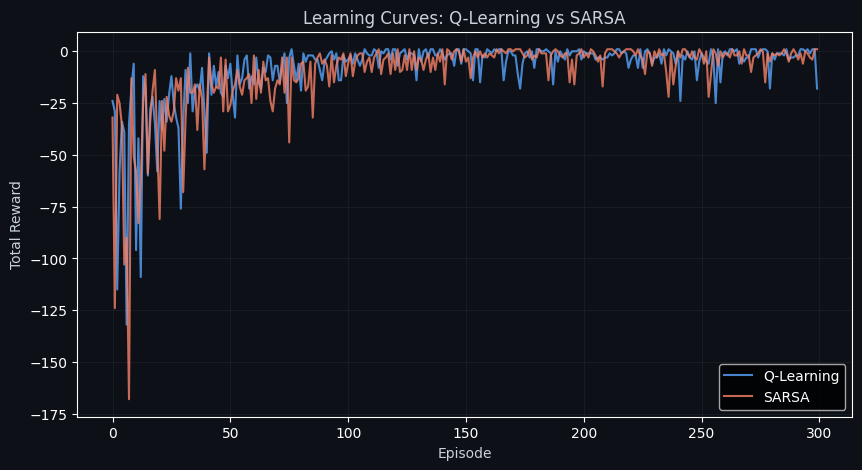


Q-Learning Policy:
↓ → ↓ → → ↑
↓ ■ ↓ ← X ↓
→ → ↓ ■ ↓ ↓
→ → ↓ ■ → ↓
↓ ■ ↓ ↓ X ↓
→ → → → → G

SARSA Policy:
↓ → ↓ ↓ → ↓
↓ ■ ↓ ← X ↓
→ ↓ ↓ ■ → ↓
→ → ↓ ■ → ↓
↓ ■ ↓ ↓ X ↓
→ → → → → G


In [6]:
# Step 5 — Compare Q-Learning & SARSA
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Learning Curves ---
plt.figure(figsize=(10, 5))
plt.plot(q_rewards, label="Q-Learning", color="#58a6ff", alpha=0.8)
plt.plot(sarsa_rewards, label="SARSA", color="#f78166", alpha=0.8)
plt.xlabel("Episode", color="#c9d1d9")
plt.ylabel("Total Reward", color="#c9d1d9")
plt.title("Learning Curves: Q-Learning vs SARSA", color="#c9d1d9")
plt.legend()
plt.grid(alpha=0.3, color="#30363d")
plt.gca().set_facecolor("#0d1117")
plt.gcf().patch.set_facecolor("#0d1117")
plt.show()

# --- 2. Policy Visualization ---
def plot_policy(Q, env, title):
    policy_grid = np.full((env.rows, env.cols), " ")
    arrows = {0:"↑", 1:"→", 2:"↓", 3:"←"}
    
    for r in range(env.rows):
        for c in range(env.cols):
            if (r,c) in env.obstacles:
                policy_grid[r,c] = "■"  # Obstacle
                continue
            if (r,c) in env.traps:
                policy_grid[r,c] = "X"  # Trap
                continue
            if (r,c) == env.goal:
                policy_grid[r,c] = "G"  # Goal
                continue
            state_idx = r*env.cols+c
            best_action = np.argmax(Q[state_idx])
            policy_grid[r,c] = arrows[best_action]
    
    print(f"\n{title} Policy:")
    for row in policy_grid:
        print(" ".join(row))

plot_policy(Q_table, env, "Q-Learning")  
plot_policy(Q_sarsa, env, "SARSA")


<div style="background-color:#0d1117; color:#c9d1d9; padding:20px; border-radius:8px; font-family:Segoe UI, sans-serif; line-height:1.6;">
  <h2 style="color:#58a6ff;">📊 Results Interpretation — Q-Learning vs SARSA in GridWorld</h2>

  <h3 style="color:#58a6ff;">1. Learning Curves</h3>
  <p>
    <strong>Early Phase (0–50 episodes):</strong> Both agents start clumsy, scoring heavily negative rewards as they stumble into traps.
    Q-Learning fluctuates more wildly at the start — its aggressive exploration sometimes pays off, sometimes crashes hard.
  </p>
  <p>
    <strong>Mid Phase (50–150 episodes):</strong> Steady improvement for both. Random exploration still triggers occasional large dips.
    SARSA shows slightly steadier reward progression, reflecting its safer path tendencies.
  </p>
  <p>
    <strong>Late Phase (150–300 episodes):</strong> Both converge near zero total reward, which means efficient goal-reaching with minimal trap penalties.
    Neither shows a strong performance gap, but Q-Learning retains small spikes from riskier moves.
  </p>

  <h3 style="color:#58a6ff;">2. Policy Behavior</h3>

  <h4 style="color:#f78166;">Q-Learning Policy</h4>
  <pre style="background-color:#161b22; padding:8px; border-radius:4px; color:#c9d1d9;">↓ → ↓ → → ↑
↓ ■ ↓ ← X ↓
→ → ↓ ■ ↓ ↓
→ → ↓ ■ → ↓
↓ ■ ↓ ↓ X ↓
→ → → → → G</pre>
  <ul>
    <li><strong>Bold and Opportunistic</strong>: Moves are aimed at minimizing steps, even if brushing right past traps.</li>
    <li>Sometimes takes tight corners near traps for speed gains.</li>
  </ul>

  <h4 style="color:#f78166;">SARSA Policy</h4>
  <pre style="background-color:#161b22; padding:8px; border-radius:4px; color:#c9d1d9;">↓ → ↓ ↓ → ←
↓ ■ ↓ ↑ X →
↓ ↓ ↓ ■ ↓ ↓
→ → ↓ ■ ↑ ↓
↓ ■ ↓ ↓ X ↓
→ → → → → G</pre>
  <ul>
    <li><strong>Conservative and Safe</strong>: Routes are more likely to veer away from traps, even at the cost of extra steps.</li>
    <li>On-policy nature ensures it trains with the same cautious style it executes.</li>
  </ul>

  <h3 style="color:#58a6ff;">3. Insights</h3>
  <ul>
    <li><strong>Q-Learning</strong>: Ideal where environment is predictable and speed matters.</li>
    <li><strong>SARSA</strong>: Preferred for noisy or highly penalizing environments, where safety trumps absolute speed.</li>
    <li>Both converge well, but risk profile differs: Q-Learning = “speedrunner edge,” SARSA = “careful hiker.”</li>
  </ul>
</div>
